# Hypothesis testing

In this notebook we demonstrate formal hypothesis testing using the [NHANES](https://www.cdc.gov/nchs/nhanes/index.htm) data.

Kindly note this notebook is strictly for my learning and knowledge sharing purpose. All this excecise, its content and code belong to Courseara - University of Michigan. While going through Week 3 of Inferential Statistical Analysis we learn all these concept and hence in this notebook we practise them through NHANES dataset.

In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
import scipy.stats.distributions as dist

Below we read the data, and convert some of the integer codes to text values.  The NHANES codebooks for
[SMQ020](https://wwwn.cdc.gov/Nchs/Nhanes/2015-2016/SMQ_I.htm#SMQ020),
[RIAGENDR](https://wwwn.cdc.gov/Nchs/Nhanes/2015-2016/DEMO_I.htm#RIAGENDR), and
[DMDCITZN](https://wwwn.cdc.gov/Nchs/Nhanes/2015-2016/DEMO_I.htm#DMDCITZN) describe the meanings of the numerical
codes.

In [2]:
da = pd.read_csv("nhanes_2015_2016.csv")

da["SMQ020x"] = da.SMQ020.replace({1: "Yes", 2: "No", 7: np.nan, 9: np.nan})  # np.nan represents a missing value
da["RIAGENDRx"] = da.RIAGENDR.replace({1: "Male", 2: "Female"})
da["DMDCITZNx"] = da.DMDCITZN.replace({1: "Yes", 2: "No", 7: np.nan, 9: np.nan})

### Hypothesis tests for one proportions

The most basic hypothesis test may be the one-sample test for a proportion.  This test is used if we have specified a particular value as the null value for the proportion, and we wish to assess if the data are compatible with the true parameter value being equal to this specified value.  One-sample tests are not used very often in practice, because it is not very common that we have a specific fixed value to use for comparison. 

For illustration, imagine that the rate of lifetime smoking in another country was known to be 40%, and we wished to assess whether the rate of lifetime smoking in the US were different from 40%.  In the following notebook cell, we carry out the (two-sided) one-sample test that the population proportion of smokers is 0.4, and obtain a p-value of 0.43.  This indicates that the NHANES data are compatible with the proportion of (ever) smokers in the US being 40%. 

In [3]:
x = da.SMQ020x.dropna() == "Yes"
p = x.mean()
se = np.sqrt(0.4 * 0.6 / len(x))
test_stat = (p - 0.4) / se
pvalue = 2*dist.norm.cdf(-np.abs(test_stat))
print(test_stat, pvalue)

0.7823563854332805 0.4340051581348052


The following cell carries out the same test as performed above using the Statsmodels library.  The results in the first (default) case below are slightly different from the results obtained above because Statsmodels by default uses the sample proportion instead of the null proportion when computing the standard error.  This distinction is rarely consequential, but we can specify that the null proportion should be used to calculate the standard error, and the results agree exactly with what we calculated above.  The first two lines below carry out tests using the normal approximation to the sampling distribution of the test statistic, and the third line below carries uses the exact binomial sampling distribution.  We can see here that the p-values are nearly identical in all three cases. This is expected when the sample size is large, and the proportion is not close to either 0 or 1.

In [4]:
# Prints test statistic, p-value
print(sm.stats.proportions_ztest(x.sum(), len(x), 0.4)) # Normal approximation with estimated proportion in SE
print(sm.stats.proportions_ztest(x.sum(), len(x), 0.4, prop_var=0.4)) # Normal approximation with null proportion in SE

# Prints the p-value
print(sm.stats.binom_test(x.sum(), len(x), 0.4)) # Exact binomial p-value

(0.7807518954896244, 0.43494843171868214)
(0.7823563854332805, 0.4340051581348052)
0.4340360854459431


### Hypothesis tests for two proportions

Comparative tests tend to be used much more frequently than tests comparing one population to a fixed value.  A two-sample test of proportions is used to assess whether the proportion of individuals with some trait differs between two sub-populations.  For example, we can compare the smoking rates between females and males. Since smoking rates vary strongly with age, we do this in the subpopulation of people between 20 and 25 years of age.  In the cell below, we carry out this test without using any libraries, implementing all the test procedures covered elsewhere in the course using Python code.  We find that the smoking rate for men is around 10 percentage points greater than the smoking rate for females, and this difference is statistically significant (the p-value is around 0.01).

In [5]:
dx = da[["SMQ020x", "RIDAGEYR", "RIAGENDRx"]].dropna()  # Drop missing values
dx = dx.loc[(dx.RIDAGEYR >= 20) & (dx.RIDAGEYR <= 25), :] # Restrict to people between 20 and 25 years old

# Summarize the data by caclculating the proportion of yes responses and the sample size
p = dx.groupby("RIAGENDRx")["SMQ020x"].agg([lambda z: np.mean(z=="Yes"), "size"])
p.columns = ["Smoke", "N"]
print(p)

# The pooled rate of yes responses, and the standard error of the estimated difference of proportions
p_comb = (dx.SMQ020x == "Yes").mean()
va = p_comb * (1 - p_comb)
se = np.sqrt(va * (1 / p.N.Female + 1 / p.N.Male))

# Calculate the test statistic and its p-value
test_stat = (p.Smoke.Female - p.Smoke.Male) / se
pvalue = 2*dist.norm.cdf(-np.abs(test_stat))
print(test_stat, pvalue)

              Smoke    N
RIAGENDRx               
Female     0.238971  272
Male       0.341270  252
-2.5833303066279414 0.009785159057508375


Essentially the same test as above can be conducted by converting the "Yes"/"No" responses to numbers (Yes=1, No=0) and conducting a two-sample t-test, as below:

In [6]:
dx_females = dx.loc[dx.RIAGENDRx=="Female", "SMQ020x"].replace({"Yes": 1, "No": 0})
dx_males = dx.loc[dx.RIAGENDRx=="Male", "SMQ020x"].replace({"Yes": 1, "No": 0})
sm.stats.ttest_ind(dx_females, dx_males) # prints test statistic, p-value, degrees of freedom

(-2.5949731446269344, 0.00972590232121254, 522.0)

### Hypothesis tests comparing means

Tests of means are similar in many ways to tests of proportions.  Just as with proportions, for comparing means there are one and two-sample tests, z-tests and t-tests, and one-sided and two-sided tests.  As with tests of proportions, one-sample tests of means are not very common, but we illustrate a one sample test in the cell below.  We compare systolic blood pressure to the fixed value 120 (which is the lower threshold for "pre-hypertension"), and find that the mean is significantly different from 120 (the point estimate of the mean is 126).

In [7]:
dx = da[["BPXSY1", "RIDAGEYR", "RIAGENDRx"]].dropna()
dx = dx.loc[(dx.RIDAGEYR >= 40) & (dx.RIDAGEYR <= 50) & (dx.RIAGENDRx == "Male"), :]
print(dx.BPXSY1.mean()) # prints mean blood pressure
sm.stats.ztest(dx.BPXSY1, value=120)  # prints test statistic, p-value

125.86698337292161


(7.469764137102597, 8.033869113167905e-14)

In the cell below, we carry out a formal test of the null hypothesis that the mean blood pressure for women between the ages of 50 and 60 is equal to the mean blood pressure of men between the ages of 50 and 60.  The results indicate that while the mean systolic blood pressure for men is slightly greater than that for women (129 mm/Hg versus 128 mm/Hg), this difference is not statistically significant. 

There are a number of different variants on the two-sample t-test. Two often-encountered variants are the t-test carried out using the t-distribution, and the t-test carried out using the normal approximation to the reference distribution of the test statistic, often called a z-test.  Below we display results from both these testing approaches.  When the sample size is large, the difference between the t-test and z-test is very small.  

In [8]:
dx = da[["BPXSY1", "RIDAGEYR", "RIAGENDRx"]].dropna()
dx = dx.loc[(dx.RIDAGEYR >= 50) & (dx.RIDAGEYR <= 60), :]
bpx_female = dx.loc[dx.RIAGENDRx=="Female", "BPXSY1"]
bpx_male = dx.loc[dx.RIAGENDRx=="Male", "BPXSY1"]
print(bpx_female.mean(), bpx_male.mean()) # prints female mean, male mean
print(sm.stats.ztest(bpx_female, bpx_male)) # prints test statistic, p-value
print(sm.stats.ttest_ind(bpx_female, bpx_male)) # prints test statistic, p-value, degrees of freedom

127.92561983471074 129.23829787234044
(-1.105435895556249, 0.2689707570859362)
(-1.105435895556249, 0.26925004137768577, 952.0)


Another important aspect of two-sample mean testing is "heteroscedasticity", meaning that the variances within the two groups being compared may be different.  While the goal of the test is to compare the means, the variances play an important role in calibrating the statistics (deciding how big the mean difference needs to be to be declared statistically significant).  In the NHANES data, we see that there are moderate differences between the amount of variation in BMI for females and for males, looking within 10-year age bands.  In every age band, females having greater variation than males.

In [9]:
dx = da[["BMXBMI", "RIDAGEYR", "RIAGENDRx"]].dropna()
da["agegrp"] = pd.cut(da.RIDAGEYR, [18, 30, 40, 50, 60, 70, 80])
da.groupby(["agegrp", "RIAGENDRx"])["BMXBMI"].agg(np.std).unstack()

RIAGENDRx,Female,Male
agegrp,,
"(18, 30]",7.745893,6.649440
"(30, 40]",8.315608,6.622412
"(40, 50]",8.076195,6.407076
"(50, 60]",7.575848,5.914373
"(60, 70]",7.604514,5.933307
"(70, 80]",6.284968,4.974855


The standard error of the mean difference (e.g. mean female blood pressure minus mean male blood pressure) can be estimated in at least two different ways.  In the statsmodels library, these approaches are referred to as the "pooled" and the "unequal" approach to estimating the variance.  If the variances are equal (i.e. there is no heteroscedasticity), then there should be little difference between the two approaches.  Even in the presence of moderate heteroscedasticity, as we have here, we can see that the results for the two methods are quite similar.  Below we have a loop that considers each 10-year age band and assesses the evidence for a difference in mean BMI for women and for men.  The results printed in each row of output are the test-statistic and p-value.

In [10]:
for k, v in da.groupby("agegrp"):
    bmi_female = v.loc[v.RIAGENDRx=="Female", "BMXBMI"].dropna()
    bmi_female = sm.stats.DescrStatsW(bmi_female)
    bmi_male = v.loc[v.RIAGENDRx=="Male", "BMXBMI"].dropna()
    bmi_male = sm.stats.DescrStatsW(bmi_male)
    print(k)
    print("pooled: ", sm.stats.CompareMeans(bmi_female, bmi_male).ztest_ind(usevar='pooled'))
    print("unequal:", sm.stats.CompareMeans(bmi_female, bmi_male).ztest_ind(usevar='unequal'))
    print()

(18, 30]
pooled:  (1.7026932933643306, 0.08862548061449803)
unequal: (1.7174610823927183, 0.08589495934713169)

(30, 40]
pooled:  (1.4378280405644919, 0.15048285114648174)
unequal: (1.4437869620833497, 0.1487989105789246)

(40, 50]
pooled:  (2.8933761158070186, 0.003811246059501354)
unequal: (2.9678691663536725, 0.0029987194174035366)

(50, 60]
pooled:  (3.362108779981383, 0.0007734964571391287)
unequal: (3.3754943901739387, 0.0007368319423226156)

(60, 70]
pooled:  (3.617240144243268, 0.00029776102103194453)
unequal: (3.628483094544553, 0.00028509141471492935)

(70, 80]
pooled:  (2.926729252512241, 0.003425469414486057)
unequal: (2.9377798867692064, 0.0033057163315194853)



### Paired tests

A common situation in applied research is to measure the same quantity multiple times on each unit of analysis.  For example, in NHANES, systolic blood pressure is measured at least two times (sometimes there is a third measurement) on each subject.  Although the measurements are repeated, there is no guarantee that the mean is the same each time, i.e. the mean blood pressure may be slightly lower on the second measurement compared to the first, since people are a bit more nervous the first time they are measured.  A paired test is a modified form of mean test that can be used when we are comparing two repeated measurements on the same unit.

A paired t-test for means is equivalent to taking the difference between the first and second measurement, and using a one-sample test to compare the mean of these differences to zero. Below we see that in the entire NHANES sample, the first measurement of systolic blood pressure is on average 0.67 mm/Hg greater than the second measurement.  While this difference is not large, it is strongly statistically significant.  That is, there is strong evidence that the mean values for the first and second blood pressure measurement differ.

In [11]:
dx = da[["BPXSY1", "BPXSY2"]].dropna()
db = dx.BPXSY1 - dx.BPXSY2
print(db.mean())
sm.stats.ztest(db)

0.6749860309182343


(9.800634425497911, 1.1188070930963587e-22)

To probe this effect further, we can divide the population into 10 year wide age bands and also stratify by gender, then carry out the paired t-test within each of the resulting 12 strata.  We see that the second systolic blood pressure measurement is always lower on average than the first.  The difference is larger for older people and for males.  The difference is statistically significant for females over 30, and for males over 60.   

Conducting many hypothesis tests and "cherry picking" the interesting results is usually a bad practice.  Here we are doing such "multiple testing" for illustration, and acknowledge that the strongest differences may be over-stated.  Nevertheless, there is a clear and consistent trend with age -- older people tend to have greater differences between their first and second blood pressure measurements than younger people.  There is also a difference between the genders, with older men having a stronger difference between the first and second blood pressure measurements than older women.  The gender difference for younger peple is less clear.

In [12]:
dx = da[["RIAGENDRx", "BPXSY1", "BPXSY2", "RIDAGEYR"]].dropna()
dx["agegrp"] = pd.cut(dx.RIDAGEYR, [18, 30, 40, 50, 60, 70, 80])
for k, g in dx.groupby(["RIAGENDRx", "agegrp"]):
    db = g.BPXSY1 - g.BPXSY2
    # print stratum definition, mean difference, sample size, test statistic, p-value
    print(k, db.mean(), db.size, sm.stats.ztest(db.values, value=0))

('Female', Interval(18, 30, closed='right')) 0.13708260105448156 569 (0.7612107360791227, 0.4465312067051751)
('Female', Interval(30, 40, closed='right')) 0.6713615023474179 426 (3.307398751951031, 0.0009416674523368051)
('Female', Interval(40, 50, closed='right')) 0.5970149253731343 469 (2.6040611621024654, 0.009212631487347644)
('Female', Interval(50, 60, closed='right')) 0.7685393258426966 445 (3.1023718750881724, 0.001919766301204196)
('Female', Interval(60, 70, closed='right')) 0.8787878787878788 396 (3.1024528501809625, 0.0019192411825181255)
('Female', Interval(70, 80, closed='right')) 1.4512820512820512 390 (5.141706875154317, 2.722536503552981e-07)
('Male', Interval(18, 30, closed='right')) 0.00390625 512 (0.01959622841647691, 0.9843654725443948)
('Male', Interval(30, 40, closed='right')) 0.46296296296296297 432 (1.9451535788714596, 0.05175649697939119)
('Male', Interval(40, 50, closed='right')) 0.17894736842105263 380 (0.7201800810138878, 0.47141412641258706)
('Male', Interva

## Power and sample size for hypothesis tests

Like nearly any analysis with data, hypothesis tests will yield more sensitive and confident results when there are larger amounts of data.  Here we will study the relationship between the sample size (amount of data), and the behavior of a hypothesis test.  For illustration, we will use the paired t-test for assessing whether the first and second systolic blood pressure measurement have different means, restricting to people between 50 and 60 years of age.

The simulation below randomly subsamples sets of 100, 200, 400, and 800 people from the 50-60 year old subset of NHANES, and conducts a paired z-test on each subsample.  This process is repeated 500 times for each sample size.  We report the fraction of these 500 trials where the p-value was smaller than 0.05.  A higher fraction of trials where p<0.05 implies that it is easier to detect a difference between the first and second blood pressure measurements.  We see that this proportion (called "statistical power") is only around 0.2 when the sample size is 100, and grows to essentially 100% when the sample size is 800.  Note that all of these subsamples are drawn from the same parent population, so there is no change from subsample to subsample in terms of whether the means are truly different.  The only thing that changes is our evidence that the difference is real.  When the sample size is small, we rarely amass such evidence.

In [13]:
all_p = []
dy = dx.loc[(dx.RIDAGEYR >= 50) & (dx.RIDAGEYR <= 60), :]
for n in 100, 200, 400, 800:
    pv = []
    for i in range(500):
        dz = dy.sample(n)
        db = dz.BPXSY1 - dz.BPXSY2
        _, p = sm.stats.ztest(db.values, value=0)
        pv.append(p)
    pv = np.asarray(pv)
    all_p.append(pv)
    print((pv <= 0.05).mean())

0.202
0.388
0.672
1.0


In the simulation code above, we saved all the p-values to the array named `all_p` so we can consider them further here.  The histogram below shows the distribution of p-values for 500 subsamples of data of size 100.  We see that there are more smaller p-values than larger ones, but not to a dramatic degree.  Some of the p-values are almost 1, indicating that the subsample mean differences were almost zero in those cases.

C:\ProgramData\Anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:ylabel='Density'>

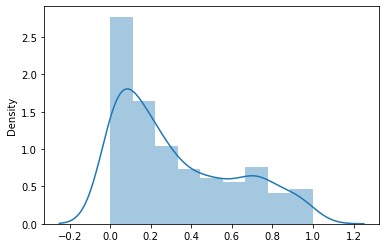

In [14]:
sns.distplot(all_p[0])

Next we inspect the distribution of p-values for subsamples of size 400.  We see that the p-values are much more concentrated close to zero compared to when we had only 100 data points.  If we obtain a sample of size 400 from this population, we have around a 70% chance of obtaining a p-value smaller than 0.05, and are very unlikely to obtain a p-value greater than 0.4.

C:\ProgramData\Anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:ylabel='Density'>

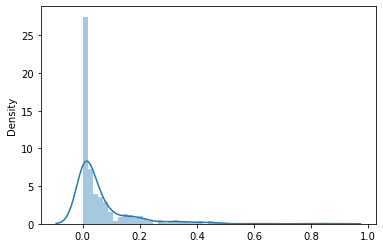

In [15]:
sns.distplot(all_p[2])